# Video Face Manipulation Detection Through Ensemble of CNNs
Image and Sound Processing Lab - Politecnico di Milano
- Nicolò Bonettini
- Edoardo Daniele Cannas
- Sara Mandelli
- Luca Bondi
- Paolo Bestagini


In [1]:
!git clone https://github.com/polimi-ispl/icpr2020dfdc
!pip install efficientnet-pytorch
!pip install -U git+https://github.com/albu/albumentations > /dev/null
%cd icpr2020dfdc/notebook

Cloning into 'icpr2020dfdc'...
remote: Enumerating objects: 645, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 645 (delta 96), reused 80 (delta 80), pack-reused 537
Receiving objects: 100% (645/645), 99.63 MiB | 16.98 MiB/s, done.
Resolving deltas: 100% (336/336), done.
Updating files: 100% (81/81), done.
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=d96c5e5f6b7f2165585051fdc48206cfe942a5f5781442ac2999d26530892bb1
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch
  Running command git clone --filter=blob:none --quiet https://github.com/albu/albumentations /tmp/pip-req-build-6txei99g
/content/icpr2020dfdc/notebook


In [63]:
import torch
from torch.utils.model_zoo import load_url
from PIL import Image
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('..')

from blazeface import FaceExtractor, BlazeFace
from architectures import fornet,weights
from isplutils import utils

In [66]:
"""
Choose an architecture between
- EfficientNetB4
- EfficientNetB4ST
- EfficientNetAutoAttB4
- EfficientNetAutoAttB4ST
- Xception
"""
net_model = 'EfficientNetB4'

"""
Choose a training dataset between
- DFDC
- FFPP
"""
train_db = 'FFPP'

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
face_policy = 'scale'
face_size = 224

model_url = weights.weight_url['{:s}_{:s}'.format(net_model,train_db)]
net = getattr(fornet,net_model)().eval().to(device)
net.load_state_dict(load_url(model_url,map_location=device,check_hash=True))

transf = utils.get_transformer(face_policy, face_size, net.get_normalizer(), train=False)

facedet = BlazeFace().to(device)
facedet.load_weights("../blazeface/blazeface.pth")
facedet.load_anchors("../blazeface/anchors.npy")
face_extractor = FaceExtractor(facedet=facedet)

Loaded pretrained weights for efficientnet-b4


Downloading: "https://f002.backblazeb2.com/file/icpr2020/EfficientNetB4_FFPP_bestval-93aaad84946829e793d1a67ed7e0309b535e2f2395acb4f8d16b92c0616ba8d7.pth" to /root/.cache/torch/hub/checkpoints/EfficientNetB4_FFPP_bestval-93aaad84946829e793d1a67ed7e0309b535e2f2395acb4f8d16b92c0616ba8d7.pth
100%|██████████| 33.9M/33.9M [00:03<00:00, 11.1MB/s]


In [67]:
def get_stats_pare(imgReal, imgFake, threshold = 0.5):
  im_real = Image.open(imgReal)
  im_fake = Image.open(imgFake)
  im_real_faces = face_extractor.process_image(img=im_real)
  im_fake_faces = face_extractor.process_image(img=im_fake)
  im_real_face = im_real_faces['faces'][0] # take the face with the highest confidence score found by BlazeFace
  im_fake_face = im_fake_faces['faces'][0] # take the face with the highest confidence score found by BlazeFace
  faces_t = torch.stack( [ transf(image=im)['image'] for im in [im_real_face,im_fake_face] ] )
  with torch.no_grad():
    faces_pred = torch.sigmoid(net(faces_t.to(device))).cpu().numpy().flatten()
    binary_predictions = (faces_pred > threshold).astype(int)
    return binary_predictions[0], binary_predictions[1] #real/fake

img_path_fake = '/content/sample_data/data/fake'
img_path_real = '/content/sample_data/data/real'

fake_files = os.listdir(img_path_fake)
real_files = os.listdir(img_path_real)

cou = len(fake_files)
predictions_real = []
predictions_fake = []

for i in range(cou):
  img_real_path = os.path.join(img_path_real, real_files[i])
  img_fake_path = os.path.join(img_path_fake, fake_files[i])

  predictions_real_one, predictions_fake_one = get_stats_pare(img_real_path, img_fake_path)
  predictions_real.append(predictions_real_one)
  predictions_fake.append(predictions_fake_one)

accurancy_real = sum(1 for i in predictions_real if i == 0)
accurancy_fake = sum(1 for i in predictions_fake if i == 1)
print('Score for REAL face: {:.4f}'.format(accurancy_real))
print('Score for FAKE face: {:.4f}'.format(accurancy_fake))

print(" ".join(map(str, predictions_real)))
print(" ".join(map(str, predictions_fake)))



Score for REAL face: 48.0000
Score for FAKE face: 18.0000
1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 1 0


## Parameters

In [ ]:
"""
Choose an architecture between
- EfficientNetB4
- EfficientNetB4ST
- EfficientNetAutoAttB4
- EfficientNetAutoAttB4ST
- Xception
"""
net_model = 'EfficientNetAutoAttB4ST'

"""
Choose a training dataset between
- DFDC
- FFPP
"""
train_db = 'FFPP'

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
face_policy = 'scale'
face_size = 224

## Initialization

In [ ]:
model_url = weights.weight_url['{:s}_{:s}'.format(net_model,train_db)]
net = getattr(fornet,net_model)().eval().to(device)
net.load_state_dict(load_url(model_url,map_location=device,check_hash=True))

Loaded pretrained weights for efficientnet-b4


Downloading: "https://f002.backblazeb2.com/file/icpr2020/EfficientNetAutoAttB4ST_FFPP_bestval-ddb357503b9b902e1b925c2550415604c4252b9b9ecafeb7369dc58cc16e9edd.pth" to /root/.cache/torch/hub/checkpoints/EfficientNetAutoAttB4ST_FFPP_bestval-ddb357503b9b902e1b925c2550415604c4252b9b9ecafeb7369dc58cc16e9edd.pth
100%|██████████| 33.9M/33.9M [00:00<00:00, 87.5MB/s]


<All keys matched successfully>

In [ ]:
transf = utils.get_transformer(face_policy, face_size, net.get_normalizer(), train=False)

In [ ]:
facedet = BlazeFace().to(device)
facedet.load_weights("../blazeface/blazeface.pth")
facedet.load_anchors("../blazeface/anchors.npy")
face_extractor = FaceExtractor(facedet=facedet)

## Load images

In [ ]:
im_real = Image.open('/content/icpr2020dfdc/notebook/samples/0000.png')
im_fake = Image.open('/content/icpr2020dfdc/notebook/samples/0001.png')

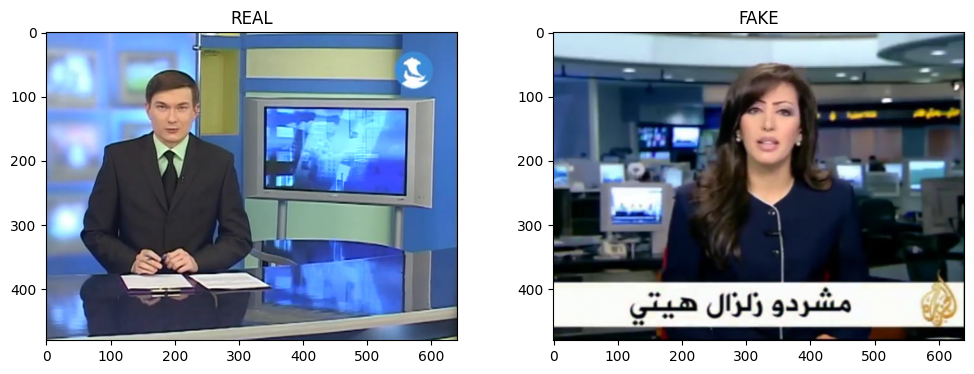

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].imshow(im_real)
ax[0].set_title('REAL')

ax[1].imshow(im_fake)
ax[1].set_title('FAKE');

## Extract faces

In [ ]:
im_real_faces = face_extractor.process_image(img=im_real)
im_fake_faces = face_extractor.process_image(img=im_fake)

In [ ]:
im_real_face = im_real_faces['faces'][0] # take the face with the highest confidence score found by BlazeFace
im_fake_face = im_fake_faces['faces'][0] # take the face with the highest confidence score found by BlazeFace

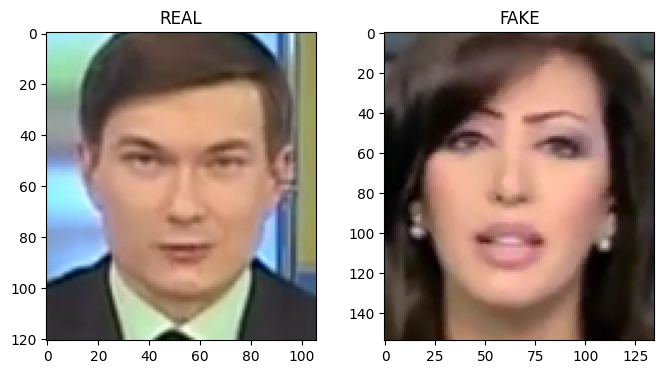

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(8,4))

ax[0].imshow(im_real_face)
ax[0].set_title('REAL')

ax[1].imshow(im_fake_face)
ax[1].set_title('FAKE');

## Predict scores

In [ ]:
faces_t = torch.stack( [ transf(image=im)['image'] for im in [im_real_face,im_fake_face] ] )

with torch.no_grad():
    faces_pred = torch.sigmoid(net(faces_t.to(device))).cpu().numpy().flatten()

In [ ]:
"""
Print scores.
A score close to 0 predicts REAL. A score close to 1 predicts FAKE.
"""
print('Score for REAL face: {:.4f}'.format(faces_pred[0]))
print('Score for FAKE face: {:.4f}'.format(faces_pred[1]))

Score for REAL face: 0.0366
Score for FAKE face: 0.2509
